In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
import collections
import itertools
from utils import *
from smoothing import *

In [189]:
def sort_spectra(eigs, evecs):
    idx = eigs.argsort()[::-1]   
    eigs = eigs[idx]
    evecs = evecs[:, idx]
    return eigs, evecs

In [209]:
# np.linalg.norm(evecs_true[:,1])
evecs_true[:, 0].sum()

5.570929466498434

In [224]:
N_dim = 32

# p_star, orig, noise, X = generate_p_star(N=N_dim,a=1.4,symmetric=True,normalized=True)

eigs_true, evecs_true = np.linalg.eig(p_star)
idx = eigs_true.argsort()[::-1]   
eigs_true = eigs_true[idx]
evecs_true = evecs_true[:,idx]

pmi_star = get_pmi_matrix(p_star,ppmi=True)

eigs_true_pmi, evecs_true_pmi = np.linalg.eig(pmi_star)
idx = eigs_true_pmi.argsort()[::-1]   
eigs_true_pmi = eigs_true_pmi[idx]
evecs_true_pmi = evecs_true_pmi[:, idx]


In [ ]:
# eig2/eig1 experiment for importance sampling

num_samples = [10000,50000,100000,200000,500000]
alphas = [0.25,0.5,0.75,1]

results = {}

for n in num_samples:

    print(n)

    results[n] = {}

    for alpha in alphas:

        results[n][alpha] = []

        for _ in range(50):

            samples = sample_from_2d(p_star,n,return_p_hat=False)
            eigs,evecs = np.linalg.eig(glove_importance_sampling(samples,alpha=alpha))
            eigs = sorted(np.abs(eigs))[::-1]
            eigs = eigs/eigs[0]

            results[n][alpha].append(eigs)

/home/bingbin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


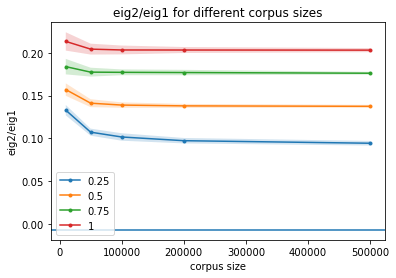

In [81]:
# plot eig1/eig2
for alpha in alphas:
    means = np.mean(np.array([results[n][alpha] for n in num_samples])[:,:,1],axis=1)
    std = np.std(np.array([results[n][alpha] for n in num_samples])[:,:,1],axis=1)

    plt.plot(num_samples,means,marker=".",label=alpha)
    plt.fill_between(num_samples,means-std,means+std,alpha=0.2)

eigs_true = sorted(eigs_true)
plt.axhline(y=(eigs_true/eigs_true[0])[1])

plt.title("eig2/eig1 for different corpus sizes")
plt.xlabel("corpus size")
plt.ylabel("eig2/eig1")

plt.legend()
plt.show()

In [362]:
# num_samples = [10000,50000,100000, 200000, 500000,
#                1000000, 2000000]
num_samples = list(range(1000, 20001, 1000))

n_trials = 100

methods = ['mle',
            'gt',
            'svd',
            'interp',
            'add_k',
            'kneser_ney',
            'importance_sampling_glove',
            'eigenvalue_weighting',
            'cds_pmi',
            'dirichlet_pmi'
          ]

# results = {}
for n in num_samples:

    print(f"Number of samples {n}")

    if n not in results:
        results[n] = {}
    else:
        continue

    for method in methods:

        results[n][method] = {'eigs' : [], 'evecs' : [], 'mat' : []}

    for _ in range(n_trials):

        samples = sample_from_2d(p_star,n,return_p_hat=False)

        # MLE estimate 
        mle = MLE_estimator(samples)
        eigs,evecs = np.linalg.eig(mle)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['mle']['eigs'].append(eigs[:2])
        results[n]['mle']['evecs'].append(evecs[:,:2])
        results[n]['mle']['mat'].append(mle )

        # Good Turing Estimator
        gt = good_turing_estimator(samples)
        eigs,evecs = np.linalg.eig(gt)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['gt']['eigs'].append(eigs[:2])
        results[n]['gt']['evecs'].append(evecs[:,:2])
        results[n]['gt']['mat'].append(gt )

        # SVD reconstruction
        svd = svd_smoothing(samples)
        eigs,evecs = np.linalg.eig(svd)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['svd']['eigs'].append(eigs[:2])
        results[n]['svd']['evecs'].append(evecs[:,:2])
        results[n]['svd']['mat'].append(svd )

        # Interpolation with uniform prior
        interp = interpolation_smoothing(samples,0.95)
        eigs,evecs = np.linalg.eig(interp)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['interp']['eigs'].append(eigs[:2])
        results[n]['interp']['evecs'].append(evecs[:,:2])
        results[n]['interp']['mat'].append(interp )

        # Add-k smoothing
        add_k = add_k_smoothing(samples,k=1)
        eigs,evecs = np.linalg.eig(add_k)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['add_k']['eigs'].append(eigs[:2])
        results[n]['add_k']['evecs'].append(evecs[:,:2])
        results[n]['add_k']['mat'].append(add_k )

        # kneser ney smoothing
        kneser_ney = kneser_ney_smoothing(samples)
        eigs,evecs = np.linalg.eig(kneser_ney)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['kneser_ney']['eigs'].append(eigs[:2])
        results[n]['kneser_ney']['evecs'].append(evecs[:,:2])
        results[n]['kneser_ney']['mat'].append(kneser_ney )

        # importance sampling (from GloVe)
        importance_sampling_glove = glove_importance_sampling(samples)
        eigs,evecs = np.linalg.eig(importance_sampling_glove)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['importance_sampling_glove']['eigs'].append(eigs[:2])
        results[n]['importance_sampling_glove']['evecs'].append(evecs[:,:2])
        results[n]['importance_sampling_glove']['mat'].append(importance_sampling_glove )

        # eigenvalue weighting 
        eigenvalue_weighting_ = eigenvalue_weighting(samples,p=0.5)
        eigs,evecs = np.linalg.eig(eigenvalue_weighting_)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['eigenvalue_weighting']['eigs'].append(eigs[:2])
        results[n]['eigenvalue_weighting']['evecs'].append(evecs[:,:2])
        results[n]['eigenvalue_weighting']['mat'].append(eigenvalue_weighting_)

        # Estimates for PMI Matrix

        # cds smoothing
        cds_pmi = cds_smoothing(samples)
        cds_ppmi = convert_to_ppmi(cds_pmi)
        eigs,evecs = np.linalg.eig(cds_ppmi)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['cds_pmi']['eigs'].append(eigs[:2])
        results[n]['cds_pmi']['evecs'].append(evecs[:,:2])
        results[n]['cds_pmi']['mat'].append(cds_ppmi)

        # dirichlet smoothing
        dirichlet_pmi = dirichlet_smoothing(samples)
        dirichlet_ppmi = convert_to_ppmi(dirichlet_pmi)
        eigs,evecs = np.linalg.eig(dirichlet_ppmi)
        eigs, evecs = sort_spectra(eigs, evecs)
        results[n]['dirichlet_pmi']['eigs'].append(eigs[:2])
        results[n]['dirichlet_pmi']['evecs'].append(evecs[:,:2])
        results[n]['dirichlet_pmi']['mat'].append(dirichlet_ppmi)
        

Number of samples 1000
Number of samples 2000
Number of samples 3000
Number of samples 4000
Number of samples 5000
Number of samples 6000
Number of samples 7000
Number of samples 8000
Number of samples 9000
Number of samples 10000


/home/bingbin/replearning/smoothing.py:118: RuntimeWarning: divide by zero encountered in log
  


Number of samples 11000
Number of samples 12000
Number of samples 13000
Number of samples 14000
Number of samples 15000
Number of samples 16000
Number of samples 17000
Number of samples 18000
Number of samples 19000
Number of samples 20000


In [87]:
import pandas as pd
df = pd.DataFrame(index=methods,columns=num_samples)

In [88]:
for method in methods:
    for n in num_samples:

        if 'pmi' not in method:
            df.loc[method][n] = (np.mean(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]),\
                np.std(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]))
        # else:
        #     df.loc[method][n] = (np.mean(np.abs(np.array(results[n][method]['eigs']) -  eigs_true[:2])[:,0]),\
        #         np.std(np.abs(np.array(results[n][method]['eigs']) -  eigs_true_pmi[:2])[:,0]),6)

In [89]:
import pandas as pd

# top evec error, l2
df2 = pd.DataFrame(index=methods,columns=num_samples)

In [90]:
for method in methods:
    for n in num_samples:

        if 'pmi' not in method:
            df2.loc[method][n] = (
                np.mean(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],axis=1)) , \
                    np.std(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],axis=1))
            )
            #  np.mean(np.abs(np.array(results[n][method]['evecs']) -  eigs_true_pmi[:2])[:,0])
        # else:
        #     df2.loc[method][n] = np.mean(np.abs(np.array(results[n][method]['evecs']) -  eigs_true[:2])[:,0])

In [92]:
# top evec error, l-inf
df3 = pd.DataFrame(index=methods,columns=num_samples)

In [93]:
for method in methods:

    for n in num_samples:

        df3.loc[method][n] = (
            np.mean(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],np.inf,axis=1))
            ,
            np.round(np.std(np.linalg.norm((np.array(results[n][method]['evecs']) - evecs_true[:,:2])[:,:,0],np.inf,axis=1)),6)
        )

In [95]:
methods

['mle',
 'gt',
 'svd',
 'interp',
 'add_k',
 'kneser_ney',
 'importance_sampling_glove',
 'eigenvalue_weighting',
 'cds_pmi',
 'dirichlet_pmi']

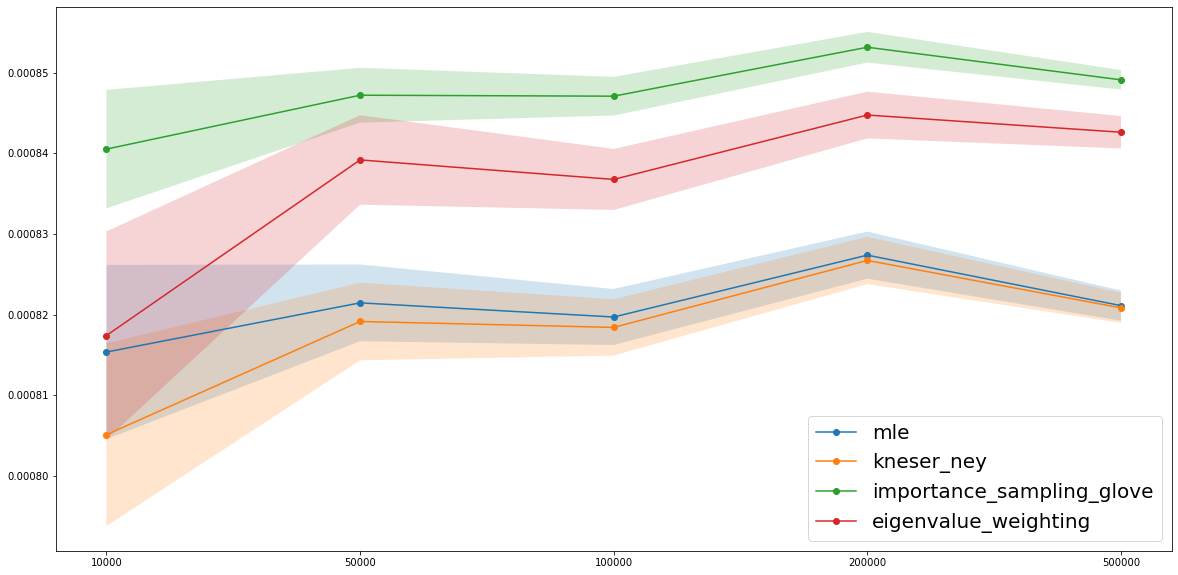

In [187]:
"""
Check eigenvalues
"""
x = range(len(num_samples))
CHECK_PMI = 0
for method in methods: # ['mle', 'kneser_ney', 'importance_sampling_glove']:

    if 'pmi' in method:
        if not CHECK_PMI: continue
        eig_true = eigs_true_pmi[:2]
        # data = [(n,np.abs(np.array(results[n][method]['eigs']) -  eigs_true_pmi[:2])[:,0]) for n in num_samples]
    else:
        if CHECK_PMI: continue
        if method in ['interp', 'gt', 'add_k', 'svd']:
            # skip methods with really bad performance
            continue
        eig_true = eigs_true[:2]

    data = [(n, np.abs(np.array(results[n][method]['eigs']) -  eig_true)[:,0]) for n in num_samples]

    # plt.boxplot(y_values, positions=range(len(num_samples)), widths=0.2,meanline=True,showmeans=True)
    # plt.plot(range(len(num_samples)), [np.mean(i) for i in y_values],label=method)
    
    y_values = [y for _,y in data]
    n_trials = len(y_values[0])
    means = np.array([y.mean() for y in y_values])
    stds = np.array([y.std() for y in y_values]) / (n_trials**0.5)
    plt.plot(x, means, marker='o', label=method)
    plt.fill_between(x, means+stds, means-stds, alpha=0.2)


plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(range(len(num_samples)), num_samples)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(fontsize="20")
# plt.ylim(0,2)
plt.show()

In [292]:
results[10000]['mle']['evecs'][0][:, 0].real * -1

array([0.1598296 , 0.19685236, 0.22067787, 0.17042058, 0.11536064,
       0.18183783, 0.16253655, 0.19273627, 0.1348873 , 0.17140326,
       0.15064987, 0.15405156, 0.14096606, 0.19753167, 0.23756232,
       0.14802785, 0.21169343, 0.13852481, 0.12936275, 0.18960736,
       0.16785575, 0.13222495, 0.17230084, 0.23898521, 0.24753278,
       0.16611688, 0.13794738, 0.18271013, 0.14054414, 0.18687033,
       0.19575663, 0.18265008])

In [280]:
np.linalg.norm(results[100000]['mle']['evecs'][0][:, 0] * -1 - results[10000]['mle']['evecs'][0][:, 0])

0.04547342428787245

In [293]:
np.linalg.norm(results[100000]['mle']['evecs'][0][:, 0].real * -1 - evecs_true[:, 0])

1.9999627337079104

In [294]:
np.abs(results[100000]['mle']['evecs'][0][:, 0].real * -1 - evecs_true[:, 0]).max()

0.49744043618636713

In [287]:
evecs_true[:, 0]

array([0.16385264, 0.1898985 , 0.22700255, 0.17150092, 0.11965124,
       0.18553682, 0.16486179, 0.20567389, 0.14475246, 0.15677741,
       0.15619498, 0.15351647, 0.15660161, 0.2049199 , 0.23080276,
       0.14852234, 0.20128729, 0.13865593, 0.13276168, 0.19228785,
       0.17471376, 0.13602195, 0.18254546, 0.22680491, 0.24708313,
       0.1670483 , 0.14904841, 0.17765311, 0.13670746, 0.17867606,
       0.17682567, 0.17274221])

In [301]:
np.abs(results[100000]['mle']['evecs'][0][:, 0].real - evecs_true[:, 0]).max()

0.003861931076372005

In [300]:
np.abs(results[10000]['mle']['evecs'][0][:, 0].real * -1 - evecs_true[:, 0]).max()

0.01893096397016461

In [310]:
top_evecs = np.array([np.array(results[n][method]['evecs'])[:,:,0] for n in num_samples])

In [314]:
top_evecs.shape

(7, 50, 32)

In [316]:
signs = np.array([(2*(each[:,0] > 0).astype(np.int)-1).reshape(-1, 1) for each in top_evecs])
print(signs.shape)

(7, 50, 1)


In [318]:
signs *= -1*gt_sign
print(signs.shape)

(7, 50, 1)


top_evecs: (20, 100, 32)
top_evecs: (20, 100, 32)
top_evecs: (20, 100, 32)
top_evecs: (20, 100, 32)
top_evecs: (20, 100, 32)
top_evecs: (20, 100, 32)


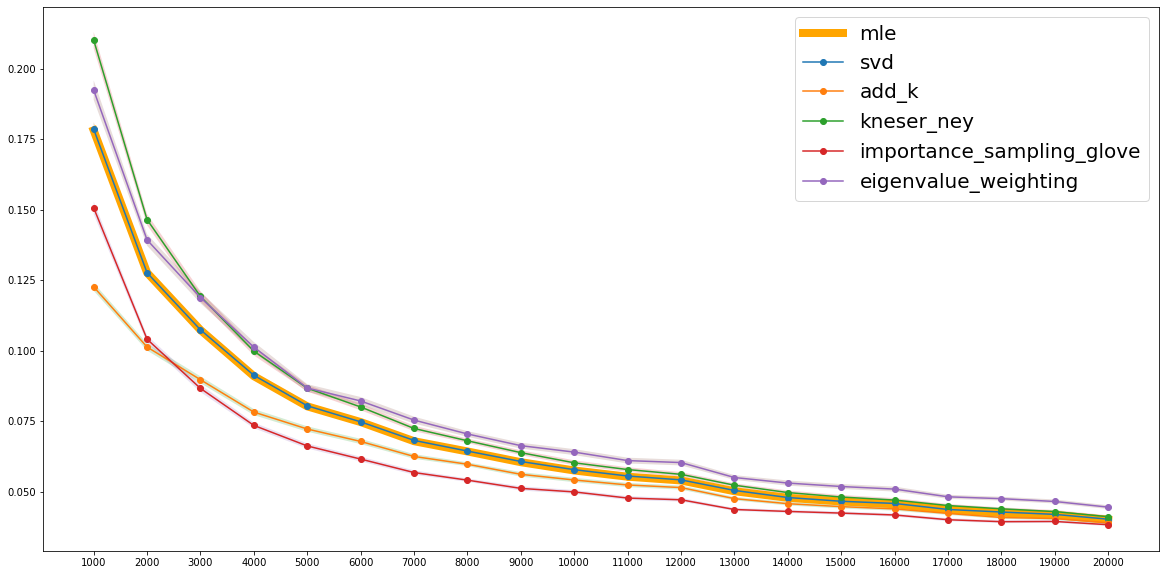

In [371]:
"""
Check eigenvectors
"""
x = range(len(num_samples))
CHECK_PMI = 0
LOSS_TYPE = 'l2'

for method in methods: # ['mle', 'kneser_ney', 'importance_sampling_glove']:
    if method in ['interp', 'gt']:
        # skip methods with really bad performance
        continue

    if 'pmi' in method:
        if not CHECK_PMI: continue
        evec_true = evecs_true_pmi[:, 0]
        # data = [(n,np.abs(np.array(results[n][method]['eigs']) -  eigs_true_pmi[:2])[:,0]) for n in num_samples]
    else:
        if CHECK_PMI: continue
        evec_true = evecs_true[:, 0]

    top_evecs = np.stack([np.array(results[n][method]['evecs'])[:,:,0] for n in num_samples])
    print("top_evecs:", top_evecs.shape)
    signs = np.array([(2*(each[:,0] > 0).astype(np.int)-1).reshape(-1, 1) for each in top_evecs])
    gt_sign = (2*evec_true[0].astype(np.int) - 1)
    signs *= -1*gt_sign

    if LOSS_TYPE == 'l2':
        data = [(n, np.linalg.norm(top_evecs[i] * signs[i] -  evec_true, axis=1))
                    for i,n in enumerate(num_samples)]
    elif LOSS_TYPE == 'l_inf':
        data = [(n, np.abs(top_evecs * signs - evec_true).max(1))
                    for n in num_samples]

    # plt.boxplot(y_values, positions=range(len(num_samples)), widths=0.2,meanline=True,showmeans=True)
    # plt.plot(range(len(num_samples)), [np.mean(i) for i in y_values],label=method)
    
    y_values = [y for _,y in data]
    n_trials = len(y_values[0])
    means = np.array([y.mean() for y in y_values])
    stds = np.array([y.std() for y in y_values]) / (n_trials**0.5)
    if method == 'mle':
        plt.plot(x, means, marker='o', label=method, color='orange', linewidth=8)
    else:
        plt.plot(x, means, marker='o', label=method)
    plt.fill_between(x, means+stds, means-stds, alpha=0.2)


plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(range(len(num_samples)), num_samples)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(fontsize="20")
# plt.ylim(0,2)
plt.show()

In [147]:
np.array(results[n][method]['evecs'])[:,:,0].shape

(50, 32, 1)

In [150]:
(np.array(results[n][method]['evecs'])[:,:,0] -  evec_true).shape

(50, 32)

In [142]:
evecs_true.shape

(32, 32)